In [2]:
import pyspark as ps
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
budget_pd = pd.read_csv('../data/Selected and Combined Spending Data.csv')

In [4]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('budget_data')
         .getOrCreate()
        )
sc = spark.sparkContext

In [5]:
spark_population = spark.read.csv('../data/population_by_county_1970_to_2018.csv',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)

In [6]:
spark_population.createOrReplaceTempView('population_tempview')

In [70]:
query = '''
select *
from population_tempview
WHERE `Year` >2002
AND `Year` < 2019
and`County` != 'San Francisco'
ORDER BY `Year`, `County`
'''

population_sql = spark.sql(query)
population_sql.show()
population_pd = population_sql.toPandas()

+------------+----+----------+
|      County|Year|Population|
+------------+----+----------+
|     Alameda|2003|   1467892|
|      Alpine|2003|      1248|
|      Amador|2003|     36656|
|       Butte|2003|    209389|
|   Calaveras|2003|     42651|
|      Colusa|2003|     19538|
|Contra Costa|2003|    984256|
|   Del Norte|2003|     27744|
|   El Dorado|2003|    166195|
|      Fresno|2003|    837256|
|       Glenn|2003|     26974|
|    Humboldt|2003|    129468|
|    Imperial|2003|    149041|
|        Inyo|2003|     18461|
|        Kern|2003|    707111|
|       Kings|2003|    136710|
|        Lake|2003|     61492|
|      Lassen|2003|     33828|
| Los Angeles|2003|   9756914|
|      Madera|2003|    130641|
+------------+----+----------+
only showing top 20 rows



In [71]:
budget_per_capita_pd = budget_pd.join(population_pd)
budget_per_capita_pd

,Entity Name,Fiscal Year,Police Protection_Total,Mental Health_Total,Drug and Alcohol Abuse Services_Total,County,Year,Population
0,Alameda,2003,67620724,162111429.0,28910904.0,Alameda,2003.0,1467892.0
1,Alpine,2003,1610553,148701.0,500356.0,Alpine,2003.0,1248.0
2,Amador,2003,5715469,1885165.0,849770.0,Amador,2003.0,36656.0
3,Butte,2003,11450959,28935820.0,4019764.0,Butte,2003.0,209389.0
4,Calaveras,2003,5672737,2007571.0,875481.0,Calaveras,2003.0,42651.0
...,...,...,...,...,...,...,...,...
964,Tulare,2019,53307829,61863607.0,11967886.0,NaN,NaN,NaN
965,Tuolumne,2019,14469092,9867872.0,NaN,NaN,NaN,NaN
966,Ventura,2019,178854389,72307069.0,26636931.0,NaN,NaN,NaN
967,Yolo,2019,15561581,34969944.0,4271340.0,NaN,NaN,NaN


In [72]:
budget_per_capita_pd.drop('County', axis=1, inplace=True)
budget_per_capita_pd.drop('Year', axis=1, inplace=True)
budget_per_capita_pd.rename(columns = {'Entity Name':'County', 'Fiscal Year':'Year'}, inplace=True)
budget_per_capita_pd['Police Spending Per Capita'] = budget_per_capita_pd['Police Protection_Total'] / budget_per_capita_pd['Population']
budget_per_capita_pd['Mental Health Spending Per Capita'] = budget_per_capita_pd['Mental Health_Total'] / budget_per_capita_pd['Population']
budget_per_capita_pd['Drug and Alcohol Abuse Services Spending Per Capita'] = budget_per_capita_pd['Drug and Alcohol Abuse Services_Total'] / budget_per_capita_pd['Population']

In [73]:
budget_per_capita_pd.to_csv('Budget Per Capita')

In [74]:
spark_budget = spark.read.csv('Budget Per Capita',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)

In [75]:
spark_budget.createOrReplaceTempView('budget_tempview')

In [76]:
#filtering out counties with any null values
query = '''
select *
from budget_tempview
Where `Year` < 2019
AND County NOT IN ('Yolo', 'Yuba', 'Fresno', 'Placer', 'Sutter', 'Mono', 'Tuolumne', 'Plumas', 'Sierra', 'San Bernardino', 'Merced', 'Santa Clara')
'''

budget_sql = spark.sql(query)
budget_sql.show()
budget_no_nulls = budget_sql.toPandas()

+---+------------+----+-----------------------+-------------------+-------------------------------------+----------+--------------------------+---------------------------------+---------------------------------------------------+
|_c0|      County|Year|Police Protection_Total|Mental Health_Total|Drug and Alcohol Abuse Services_Total|Population|Police Spending Per Capita|Mental Health Spending Per Capita|Drug and Alcohol Abuse Services Spending Per Capita|
+---+------------+----+-----------------------+-------------------+-------------------------------------+----------+--------------------------+---------------------------------+---------------------------------------------------+
|  0|     Alameda|2003|               67620724|       1.62111429E8|                          2.8910904E7| 1467892.0|         46.06655258016257|               110.43825363173858|                                  19.69552528387647|
|  1|      Alpine|2003|                1610553|           148701.0|             

In [78]:
budget_no_nulls.drop(columns='_c0', axis=1, inplace=True)
budget_no_nulls.tail(60)

,County,Year,Police Protection_Total,Mental Health_Total,Drug and Alcohol Abuse Services_Total,Population,Police Spending Per Capita,Mental Health Spending Per Capita,Drug and Alcohol Abuse Services Spending Per Capita
660,San Diego,2017,373344412,3.682998e+08,59315717.0,3309509.0,112.809608,111.285319,17.922815
661,San Joaquin,2017,73129772,1.019147e+08,18627179.0,747263.0,97.863499,136.384015,24.927206
662,San Luis Obispo,2017,35114234,5.038374e+07,11621064.0,279210.0,125.762809,180.451073,41.621231
663,San Mateo,2017,133929951,1.536674e+08,21706113.0,770256.0,173.877193,199.501747,28.180388
664,Santa Barbara,2017,75226214,8.587877e+07,12031378.0,450025.0,167.160078,190.831112,26.734910
665,Santa Cruz,2017,36481866,5.774193e+07,8124857.0,276504.0,131.939740,208.828567,29.384230
666,Shasta,2017,22881835,3.198006e+07,3281289.0,178148.0,128.442840,179.513988,18.418893
667,Siskiyou,2017,8088033,9.113498e+06,1483800.0,44615.0,181.285061,204.269820,33.257873
668,Solano,2017,86488367,6.905126e+07,5258384.0,436640.0,198.077059,158.142323,12.042836
669,Sonoma,2017,84069011,6.668286e+07,10625639.0,504613.0,166.600962,132.146532,21.057006


In [79]:
police_dict = {}
for county in budget_no_nulls['County'].unique():
    police_dict[county] = list(budget_no_nulls[budget_no_nulls.County==county]['Police Spending Per Capita'].values)
del police_dict['Alpine']

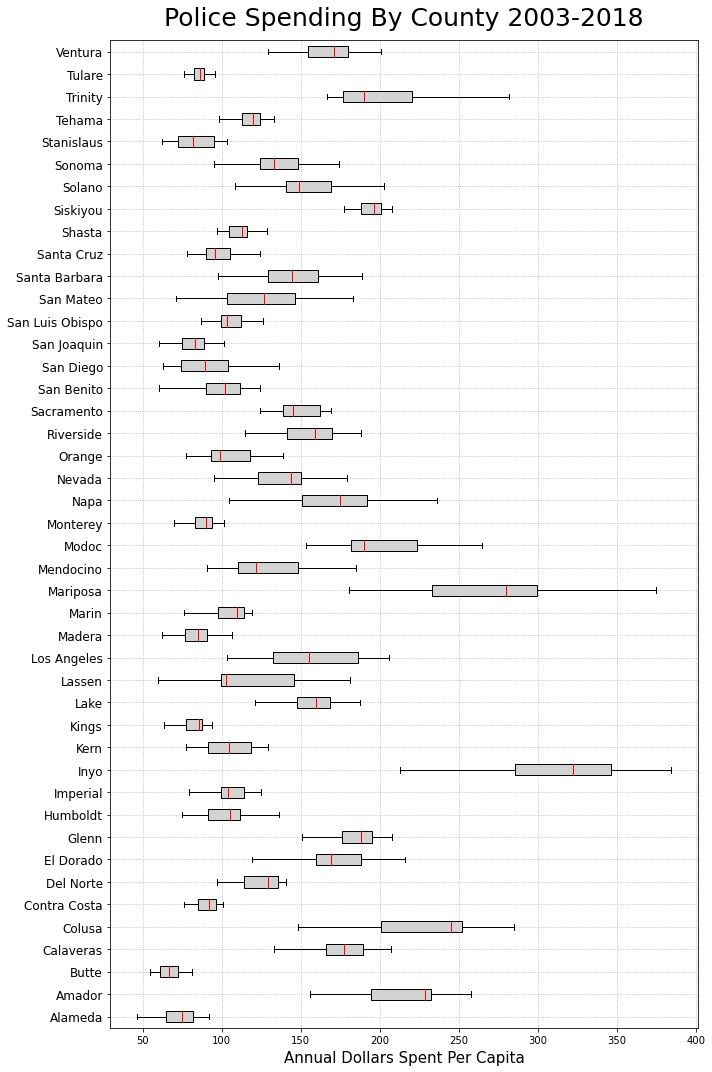

In [80]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.boxplot(police_dict.values(), vert=False, showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightgrey', color='black'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='red', markeredgecolor='red'),
            medianprops=dict(color='red'))

ax.set_yticklabels(police_dict.keys(), fontsize=12)
ax.set_xlabel('Annual Dollars Spent Per Capita', fontsize=15, labelpad=5)
ax.set_title('Police Spending By County 2003-2018', fontsize=25, pad=15)
ax.grid(linestyle=':')
fig.tight_layout()
#plt.savefig('Police Spending Boxplot (with Alpine)')

In [81]:
police_means = budget_no_nulls.groupby('County').mean('Police Spending Per Capita').sort_values('Police Spending Per Capita', ascending=False)
police_means.index

Index(['Alpine', 'Inyo', 'Mariposa', 'Colusa', 'Amador', 'Trinity', 'Modoc',
       'Siskiyou', 'Glenn', 'Calaveras', 'Napa', 'El Dorado', 'Ventura',
       'Lake', 'Los Angeles', 'Riverside', 'Sacramento', 'Solano',
       'Santa Barbara', 'Nevada', 'Sonoma', 'Mendocino', 'San Mateo',
       'Del Norte', 'Lassen', 'Tehama', 'Shasta', 'Kern', 'Marin', 'Orange',
       'San Luis Obispo', 'Humboldt', 'Imperial', 'San Benito', 'Santa Cruz',
       'Contra Costa', 'San Diego', 'Monterey', 'Madera', 'Tulare',
       'Stanislaus', 'Kings', 'San Joaquin', 'Alameda', 'Butte'],
      dtype='object', name='County')

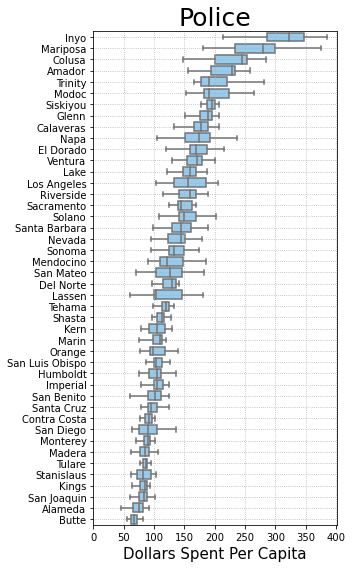

In [144]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x=budget_no_nulls['Police Spending Per Capita'], y=budget_no_nulls['County']
            , order=['Inyo', 'Mariposa', 'Colusa', 'Amador', 'Trinity', 'Modoc',
                       'Siskiyou', 'Glenn', 'Calaveras', 'Napa', 'El Dorado', 'Ventura',
                       'Lake', 'Los Angeles', 'Riverside', 'Sacramento', 'Solano',
                       'Santa Barbara', 'Nevada', 'Sonoma', 'Mendocino', 'San Mateo',
                       'Del Norte', 'Lassen', 'Tehama', 'Shasta', 'Kern', 'Marin', 'Orange',
                       'San Luis Obispo', 'Humboldt', 'Imperial', 'San Benito', 'Santa Cruz',
                       'Contra Costa', 'San Diego', 'Monterey', 'Madera', 'Tulare',
                       'Stanislaus', 'Kings', 'San Joaquin', 'Alameda', 'Butte']
            , color='lightskyblue', fliersize=0)
ax.set_xticks(np.arange(0,401, 50))
ax.set_title('Police', fontsize=25)
ax.set_ylabel('')
ax.set_xlabel('Dollars Spent Per Capita', fontsize=15)
ax.grid(linestyle=':', zorder=0)
fig.tight_layout()
plt.savefig('Ranked by Police Spending')

In [88]:
mentalhealth_means = budget_no_nulls.groupby('County').mean('Mental Health Spending Per Capita').sort_values('Mental Health Spending Per Capita', ascending=False)
mentalhealth_means.index

Index(['Alpine', 'Trinity', 'Modoc', 'Siskiyou', 'Glenn', 'Mendocino',
       'Humboldt', 'Inyo', 'Colusa', 'Santa Cruz', 'Del Norte', 'Butte',
       'Mariposa', 'Alameda', 'Lassen', 'Imperial', 'San Mateo',
       'Santa Barbara', 'Napa', 'Marin', 'Los Angeles', 'Shasta', 'Monterey',
       'Nevada', 'Tehama', 'Lake', 'San Luis Obispo', 'Stanislaus',
       'Contra Costa', 'Solano', 'San Joaquin', 'Sonoma', 'Tulare', 'Amador',
       'Kern', 'Calaveras', 'San Diego', 'Kings', 'Madera', 'Sacramento',
       'San Benito', 'Riverside', 'El Dorado', 'Orange', 'Ventura'],
      dtype='object', name='County')

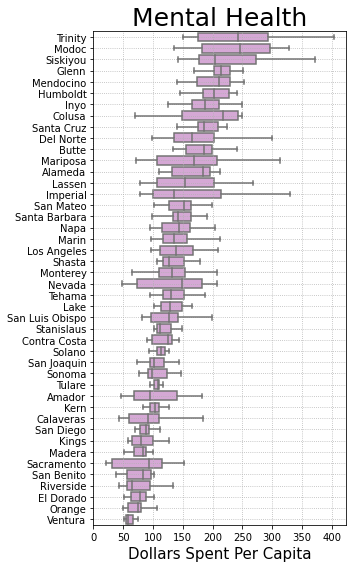

In [145]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x=budget_no_nulls['Mental Health Spending Per Capita'], y=budget_no_nulls['County']
            , order=['Trinity', 'Modoc', 'Siskiyou', 'Glenn', 'Mendocino',
                       'Humboldt', 'Inyo', 'Colusa', 'Santa Cruz', 'Del Norte', 'Butte',
                       'Mariposa', 'Alameda', 'Lassen', 'Imperial', 'San Mateo',
                       'Santa Barbara', 'Napa', 'Marin', 'Los Angeles', 'Shasta', 'Monterey',
                       'Nevada', 'Tehama', 'Lake', 'San Luis Obispo', 'Stanislaus',
                       'Contra Costa', 'Solano', 'San Joaquin', 'Sonoma', 'Tulare', 'Amador',
                       'Kern', 'Calaveras', 'San Diego', 'Kings', 'Madera', 'Sacramento',
                       'San Benito', 'Riverside', 'El Dorado', 'Orange', 'Ventura']
           , color='plum', fliersize=0)
ax.set_xticks(np.arange(0,401, 50))
ax.set_title('Mental Health', fontsize=25)
ax.set_ylabel('')
ax.set_xlabel('Dollars Spent Per Capita', fontsize=15)
ax.grid(linestyle=':', zorder=0)
fig.tight_layout()
plt.savefig('Ranked by Mental Health Spending')

In [85]:
substanceabuse_means = budget_no_nulls.groupby('County').mean('Drug and Alcohol Abuse Services Spending Per Capita').sort_values('Drug and Alcohol Abuse Services Spending Per Capita', ascending=False)
substanceabuse_means.index

Index(['Alpine', 'Modoc', 'Trinity', 'Glenn', 'Lake', 'Inyo', 'Mariposa',
       'Colusa', 'Lassen', 'Napa', 'Sonoma', 'Marin', 'Santa Cruz', 'Tehama',
       'Mendocino', 'San Luis Obispo', 'Santa Barbara', 'San Mateo',
       'Calaveras', 'Del Norte', 'Shasta', 'Ventura', 'Butte', 'Amador',
       'Tulare', 'Siskiyou', 'San Joaquin', 'San Benito', 'Alameda',
       'Los Angeles', 'Nevada', 'Sacramento', 'San Diego', 'Humboldt', 'Kern',
       'El Dorado', 'Imperial', 'Stanislaus', 'Contra Costa', 'Solano',
       'Kings', 'Riverside', 'Monterey', 'Orange', 'Madera'],
      dtype='object', name='County')

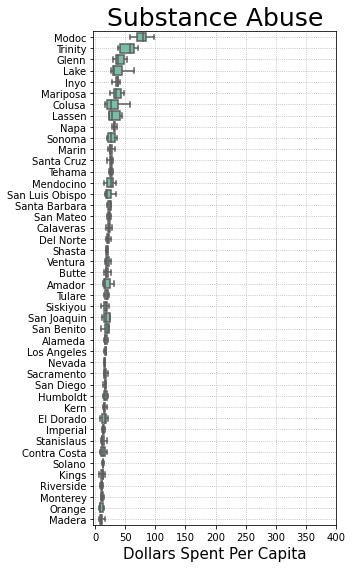

In [147]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x=budget_no_nulls['Drug and Alcohol Abuse Services Spending Per Capita'], y=budget_no_nulls['County']
            , order=['Modoc', 'Trinity', 'Glenn', 'Lake', 'Inyo', 'Mariposa',
                       'Colusa', 'Lassen', 'Napa', 'Sonoma', 'Marin', 'Santa Cruz', 'Tehama',
                       'Mendocino', 'San Luis Obispo', 'Santa Barbara', 'San Mateo',
                       'Calaveras', 'Del Norte', 'Shasta', 'Ventura', 'Butte', 'Amador',
                       'Tulare', 'Siskiyou', 'San Joaquin', 'San Benito', 'Alameda',
                       'Los Angeles', 'Nevada', 'Sacramento', 'San Diego', 'Humboldt', 'Kern',
                       'El Dorado', 'Imperial', 'Stanislaus', 'Contra Costa', 'Solano',
                       'Kings', 'Riverside', 'Monterey', 'Orange', 'Madera']
            , color='mediumaquamarine', fliersize=0)
ax.set_xticks(np.arange(0,401, 50))
ax.set_title('Substance Abuse', fontsize=25)
ax.set_ylabel('')
ax.set_xlabel('Dollars Spent Per Capita', fontsize=15)
ax.grid(linestyle=':', zorder=0)
fig.tight_layout()
plt.savefig('Ranked by Substance Abuse Spending')

In [87]:
#lets look at which budget categories each county prioritized
#by taking the average spending for the first 5 years 
#and comparing that to the averages for the last 5 years

budget_no_nulls.to_csv('clean_budget.csv')

clean_budget_sql = spark.read.csv('clean_budget.csv',
                    header=True,
                    quote='"',
                    sep=",",
                    inferSchema=True)


In [ ]:
clean_budget_sql.createOrReplaceTempView('clean_budget_sql')

In [ ]:
query = '''
select `County`, avg(`Police Spending Per Capita`) AS first_5
from clean_budget_sql
WHERE `Year` <2008
group by `County`
ORDER BY `County`
'''

budget_sql2 = spark.sql(query)
budget_sql2.show()
first_5_avg_police = budget_sql2.toPandas()

In [ ]:
query = '''
select `County`, avg(`Police Spending Per Capita`) AS last_5
from clean_budget_sql
WHERE `Year` >2013
group by `County`
ORDER BY `County`
'''

budget_sql3 = spark.sql(query)
budget_sql3.show()
last_5_avg_police = budget_sql3.toPandas()

In [ ]:
police_spending_diff = pd.concat([first_5_avg_police, last_5_avg_police['last_5']], axis=1)
police_spending_diff['diff'] = police_spending_diff['last_5'] - police_spending_diff['first_5']
police_spending_diff.sort_values('diff', ascending=False, inplace=True)
police_spending_diff[:10]['County']

In [ ]:
query = '''
select `County`, avg(`Mental Health Spending Per Capita`) AS first_5
from clean_budget_sql
WHERE `Year` <2008
group by `County`
ORDER BY `County`
'''

budget_sql5 = spark.sql(query)
budget_sql5.show()
first_5_avg_mentalhealth = budget_sql5.toPandas()

In [ ]:
query = '''
select `County`, avg(`Mental Health Spending Per Capita`) AS last_5
from clean_budget_sql
WHERE `Year` >2013
group by `County`
ORDER BY `County`
'''

budget_sql6 = spark.sql(query)
budget_sql6.show()
last_5_avg_mentalhealth = budget_sql6.toPandas()

In [ ]:
mentalhealth_spending_diff = pd.concat([first_5_avg_mentalhealth, last_5_avg_mentalhealth['last_5']], axis=1)
mentalhealth_spending_diff['diff'] = mentalhealth_spending_diff['last_5'] - mentalhealth_spending_diff['first_5']
mentalhealth_spending_diff.sort_values('diff', ascending=False, inplace=True)
list(mentalhealth_spending_diff[:10]['County'])

In [9]:
mentalhealth_spending_diff.head(20)

NameError: name 'mentalhealth_spending_diff' is not defined

In [158]:
budget_proportions = budget_no_nulls.drop(columns=['Population', 'Police Spending Per Capita'
                              , 'Mental Health Spending Per Capita'
                              , 'Drug and Alcohol Abuse Services Spending Per Capita'])
budget_proportions['Total'] = budget_proportions['Police Protection_Total'] + budget_proportions['Mental Health_Total'] + budget_proportions['Drug and Alcohol Abuse Services_Total']
budget_proportions['Proportion Police'] = budget_proportions['Police Protection_Total'] / budget_proportions['Total']
budget_proportions['Proportion Mental Health'] = budget_proportions['Mental Health_Total'] / budget_proportions['Total']
budget_proportions['Proportion Substance Abuse'] = budget_proportions['Drug and Alcohol Abuse Services_Total'] / budget_proportions['Total']
budget_proportions.drop(columns=['Police Protection_Total', 'Mental Health_Total', 'Drug and Alcohol Abuse Services_Total', 'Total'], inplace=True)

In [159]:
budget_proportions

,County,Year,Proportion Police,Proportion Mental Health,Proportion Substance Abuse
0,Alameda,2003,0.261444,0.626777,0.111779
1,Alpine,2003,0.712757,0.065808,0.221435
2,Amador,2003,0.676355,0.223086,0.100560
3,Butte,2003,0.257866,0.651612,0.090522
4,Calaveras,2003,0.663029,0.234645,0.102326
...,...,...,...,...,...
715,Stanislaus,2018,0.342936,0.583716,0.073348
716,Tehama,2018,0.399337,0.525571,0.075093
717,Trinity,2018,0.376450,0.548078,0.075471
718,Tulare,2018,0.433552,0.472185,0.094262


In [161]:
police_proportion_means = budget_proportions.groupby('County').mean().sort_values('Proportion Police', ascending=False)
police_proportion_means.index

Index(['Alpine', 'Ventura', 'El Dorado', 'Riverside', 'Amador', 'Sacramento',
       'Calaveras', 'Inyo', 'Mariposa', 'Orange', 'Solano', 'San Benito',
       'Colusa', 'Sonoma', 'Los Angeles', 'Nevada', 'Napa', 'Madera', 'Lake',
       'Kern', 'Kings', 'San Diego', 'Santa Barbara', 'Siskiyou', 'Tehama',
       'Glenn', 'Contra Costa', 'San Luis Obispo', 'San Mateo', 'Shasta',
       'Trinity', 'Tulare', 'Imperial', 'Modoc', 'San Joaquin', 'Marin',
       'Del Norte', 'Monterey', 'Lassen', 'Stanislaus', 'Mendocino',
       'Santa Cruz', 'Humboldt', 'Alameda', 'Butte'],
      dtype='object', name='County')

In [162]:
mentalhealth_proportion_means = budget_proportions.groupby('County').mean().sort_values('Proportion Mental Health', ascending=False)
mentalhealth_proportion_means.index

Index(['Butte', 'Alameda', 'Humboldt', 'Santa Cruz', 'Mendocino', 'Monterey',
       'Stanislaus', 'Imperial', 'Del Norte', 'Contra Costa', 'San Joaquin',
       'Shasta', 'Marin', 'Siskiyou', 'San Mateo', 'Lassen', 'Tulare',
       'San Luis Obispo', 'Glenn', 'Tehama', 'Trinity', 'Kings',
       'Santa Barbara', 'Kern', 'Madera', 'San Diego', 'Modoc', 'Los Angeles',
       'Nevada', 'Solano', 'Napa', 'Colusa', 'Lake', 'Sonoma', 'San Benito',
       'Orange', 'Inyo', 'Mariposa', 'Calaveras', 'Riverside', 'Sacramento',
       'Amador', 'El Dorado', 'Ventura', 'Alpine'],
      dtype='object', name='County')

In [163]:
substanceabuse_proportion_means = budget_proportions.groupby('County').mean().sort_values('Proportion Substance Abuse', ascending=False)
substanceabuse_proportion_means.index

Index(['Modoc', 'Lake', 'Lassen', 'Alpine', 'Trinity', 'Sonoma', 'Marin',
       'Napa', 'San Benito', 'San Luis Obispo', 'Glenn', 'Tulare', 'Tehama',
       'San Joaquin', 'San Diego', 'Santa Cruz', 'Colusa', 'Ventura',
       'Calaveras', 'San Mateo', 'Mariposa', 'Santa Barbara', 'Shasta',
       'Butte', 'Alameda', 'Mendocino', 'Sacramento', 'Del Norte', 'Inyo',
       'Kern', 'Kings', 'Nevada', 'Amador', 'Stanislaus', 'Contra Costa',
       'Madera', 'El Dorado', 'Orange', 'Los Angeles', 'Imperial', 'Humboldt',
       'Monterey', 'Riverside', 'Solano', 'Siskiyou'],
      dtype='object', name='County')